In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten

from pylab import plt, mpl

plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

data = pd.read_pickle('../data/BTC.pkl.gz', compression='gzip')
data[['open', 'high', 'low', 'close', 'volume']] = data[['open', 'high', 'low', 'close', 'volume']].astype(float)
print(data.head())
print(data.info())

C:\Users\yunji\AppData\Local\Temp\ipykernel_30712\2157062.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


              datetime    open    high     low   close  volume
0  2019-12-16 14:09:00  7080.0  7080.0  7080.0  7080.0     4.0
1  2019-12-16 14:10:00  7080.0  7080.0  7080.0  7080.0     0.0
2  2019-12-16 14:11:00  7080.0  7080.0  7080.0  7080.0     0.0
3  2019-12-16 14:12:00  7080.0  7080.0  7080.0  7080.0     0.0
4  2019-12-16 14:13:00  7080.0  7080.0  7080.0  7080.0     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267997 entries, 0 to 2267996
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   datetime  object 
 1   open      float64
 2   high      float64
 3   low       float64
 4   close     float64
 5   volume    float64
dtypes: float64(5), object(1)
memory usage: 103.8+ MB
None


In [19]:
data = data.iloc[-10000:,::]

In [20]:
lags = 5
features = ['close', 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']


def add_lags(data, symbol, lags, window=20, features=features):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] =  df['close'].pct_change()
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    # df['d'] = df['r']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols


data, cols = add_lags(data, 'close', lags, window=20, features=features)
split = int(len(data) * 0.8)
train = data.iloc[:split].copy()
mu, std = train[cols].mean(), train[cols].std()
train[cols] = (train[cols] - mu) / std
test = data.iloc[split:].copy()
test[cols] = (test[cols] - mu) / std






In [21]:
test

,datetime,open,high,low,close,volume,r,sma,min,max,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
2266002,2024-04-07 04:51:00,68322.7,68345.7,68322.7,68345.7,3250.0,0.000338,68310.035,68259.5,68345.7,...,0.103635,0.030410,-0.030550,-0.045354,0.005506,-1.050752,-1.067134,-1.087786,-1.088454,-1.071283
2266003,2024-04-07 04:52:00,68347.0,68365.9,68345.2,68365.8,1536.0,0.000294,68312.460,68259.5,68365.8,...,0.135358,0.103652,0.030437,-0.030532,-0.045319,-1.037456,-1.050894,-1.067279,-1.087933,-1.088587
2266004,2024-04-07 04:53:00,68365.8,68365.9,68347.7,68353.9,742.0,-0.000174,68313.760,68259.5,68365.8,...,0.217439,0.135374,0.103678,0.030455,-0.030497,-1.021636,-1.037597,-1.051037,-1.067424,-1.088066
2266005,2024-04-07 04:54:00,68353.9,68388.0,68353.9,68379.0,1226.0,0.000367,68316.855,68259.5,68379.0,...,0.122236,0.217455,0.135401,0.103696,0.030490,-1.016251,-1.021776,-1.037739,-1.051182,-1.067556
2266006,2024-04-07 04:55:00,68379.0,68379.1,68355.9,68356.0,1004.0,-0.000336,68319.445,68259.5,68379.0,...,0.274130,0.122253,0.217481,0.135418,0.103730,-0.999539,-1.016390,-1.021918,-1.037883,-1.051313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2267992,2024-04-08 14:01:00,69749.9,69780.6,69749.9,69780.5,3219.0,0.000439,69741.245,69674.1,69803.0,...,0.678572,0.508053,0.415968,0.506472,0.466614,-0.828531,-0.844394,-0.854398,-0.869150,-0.860764
2267993,2024-04-08 14:02:00,69780.5,69804.0,69780.5,69792.0,3654.0,0.000165,69747.140,69682.0,69803.0,...,0.683681,0.678588,0.508078,0.415985,0.506504,-0.826497,-0.828659,-0.844525,-0.854530,-0.869271
2267994,2024-04-08 14:03:00,69792.1,69831.1,69792.0,69820.2,11465.0,0.000404,69754.050,69695.0,69820.2,...,0.501224,0.683697,0.678612,0.508095,0.416018,-0.918121,-0.826625,-0.828789,-0.844657,-0.854650
2267995,2024-04-08 14:04:00,69820.1,69824.4,69809.3,69810.3,4769.0,-0.000142,69759.565,69695.0,69820.2,...,0.585279,0.501240,0.683721,0.678629,0.508127,-0.898913,-0.918255,-0.826755,-0.828920,-0.844776


C:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 36, 96)              │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3456)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │          34,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,157 (137.33 KB)

 Trainable params: 35,157 (137.33 KB)

 Non-trainable params: 0 (0.00 B)

None


<Axes: >

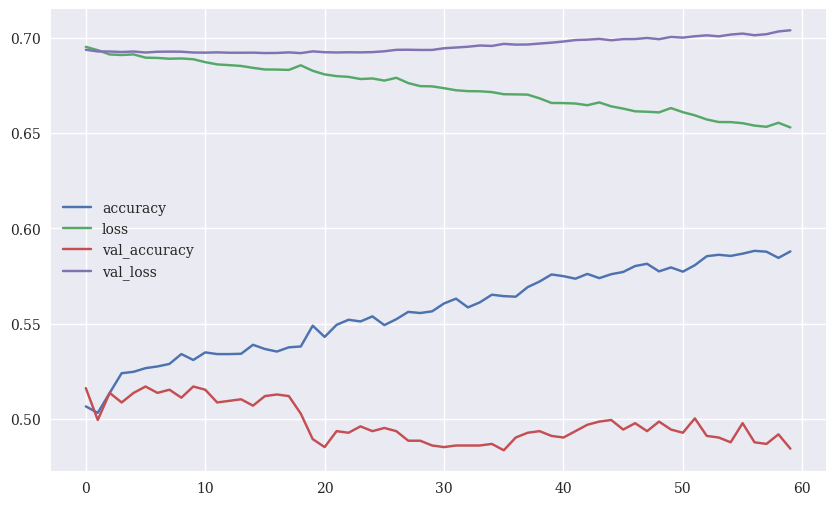

In [22]:
# Using TensorFlow backend.
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


set_seeds()
model = Sequential()
model.add(Conv1D(filters=96, kernel_size=5, activation='relu',
                 input_shape=(len(cols), 1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

model.fit(np.atleast_3d(train[cols]), train['d'],
          epochs=60, batch_size=48, verbose=False,
          validation_split=0.15, shuffle=False)

res = pd.DataFrame(model.history.history)
res.tail(3)
res.plot(figsize=(10, 6))

In [23]:
model.evaluate(np.atleast_3d(test[cols]), test['d'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4976 - loss: 0.7001


[0.7020742893218994, 0.5012531280517578]

In [24]:
model.predict(np.atleast_3d(test[cols]))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[0.5236409],
       [0.5236409],
       [0.5236409],
       ...,
       [0.5236409],
       [0.5236409],
       [0.5236409]], dtype=float32)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


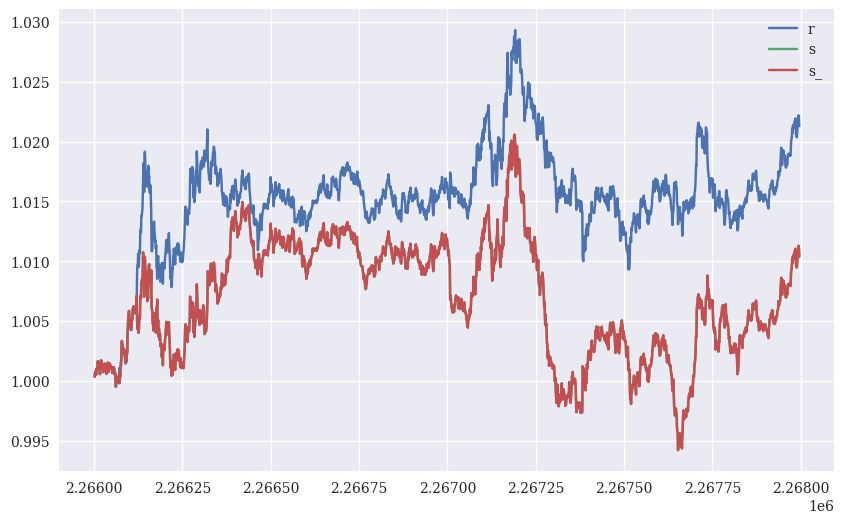

In [25]:
test['p'] = np.where(model.predict(np.atleast_3d(test[cols])) > 0.5, 1, 0)
test['p'] = np.where(test['p'] > 0, 1, -1)
test['p'].value_counts()

(test['p'].diff() != 0).sum()

test['s'] = test['p'] * test['r']
ptc = 0.00012 / test['close']
test['s_'] = np.where(test['p'] != 0, test['s'] - ptc, test['s'])
test[['r', 's', 's_']].sum().apply(np.exp)
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6))

plt.show()